In [1]:
import json
import random
import numpy as np
import pandas as pd

In [2]:
import utils.editor as edit

from utils.plotter import plot_gantt_jobs
from utils.plotter import plot_gantt_machines

from utils.checker import check_all_constraints

from utils.scheduler import generate_job_arrivals
from utils.scheduler import solve_jobshop_optimal
from utils.scheduler import solve_stage2_early_starts

In [3]:
def print_jobs_compact(job_dict):
    for job, tasks in job_dict.items():
        print(f"{job}:\t{tasks}")

# Matrix-List -----------------------------------------------
def add_job_matrix_to_list(job_set_list, new_instance):
    matrix_index = len(job_set_list)
    job_set_list.append({
        f"Job {matrix_index:02d}_{i}": ops
        for i, ops in enumerate(new_instance.values())
    })

def create_job_matrix_variants_list(instance, num_variants=5):
    job_set_list = []
    for _ in range(num_variants):
        add_job_matrix_to_list(job_set_list, instance)
    return job_set_list

In [4]:
# Datei laden
with open("data/jobshop_instances_named.json", "r", encoding="utf-8") as f:
    jobshop_instances = json.load(f)

instance =  jobshop_instances["instance ft10"]

## Day 0

In [6]:
# Matrix Liste erstellen (1 Tag)
job_set_list = create_job_matrix_variants_list(instance, 1)
for idx, job_set in enumerate(job_set_list):
    print(f"\n--- Jobset {idx} ---")
    print_jobs_compact(job_set)


--- Jobset 0 ---
Job 00_0:	[[0, 29], [1, 78], [2, 9], [3, 36], [4, 49], [5, 11], [6, 62], [7, 56], [8, 44], [9, 21]]
Job 00_1:	[[0, 43], [2, 90], [4, 75], [9, 11], [3, 69], [1, 28], [6, 46], [5, 46], [7, 72], [8, 30]]
Job 00_2:	[[1, 91], [0, 85], [3, 39], [2, 74], [8, 90], [5, 10], [7, 12], [6, 89], [9, 45], [4, 33]]
Job 00_3:	[[1, 81], [2, 95], [0, 71], [4, 99], [6, 9], [8, 52], [7, 85], [3, 98], [9, 22], [5, 43]]
Job 00_4:	[[2, 14], [0, 6], [1, 22], [5, 61], [3, 26], [4, 69], [8, 21], [7, 49], [9, 72], [6, 53]]
Job 00_5:	[[2, 84], [1, 2], [5, 52], [3, 95], [8, 48], [9, 72], [0, 47], [6, 65], [4, 6], [7, 25]]
Job 00_6:	[[1, 46], [0, 37], [3, 61], [2, 13], [6, 32], [5, 21], [9, 32], [8, 89], [7, 30], [4, 55]]
Job 00_7:	[[2, 31], [0, 86], [1, 46], [5, 74], [4, 32], [6, 88], [8, 19], [9, 48], [7, 36], [3, 79]]
Job 00_8:	[[0, 76], [1, 69], [3, 76], [5, 51], [2, 85], [9, 11], [6, 40], [7, 89], [4, 26], [8, 74]]
Job 00_9:	[[1, 85], [0, 13], [2, 61], [6, 7], [8, 64], [9, 76], [5, 47], [3, 5

In [7]:
remaining_jobs = None  # Keine übrig gebliebenen Jobs am Anfang

In [8]:
matrix_index = 0 
this_day_jobs = job_set_list[matrix_index]

# Schritt 1: neue Ankunftszeiten erzeugen
df_arrivals = generate_job_arrivals(this_day_jobs, u_b_mmax=0.9, day_id=matrix_index)
df_arrivals

# Falls noch verbliebene Job-Operationen vom Vortag da sind, hinzufügen
if remaining_jobs is not None:
    df_arrivals = edit.add_remaining_jobs_with_zero_arrival(df_arrivals, remaining_jobs, day_id=matrix_index)
    this_day_jobs = edit.merge_jssp_jobs(this_day_jobs, remaining_jobs)
    print(f"--- Erweiterte Jobs durch verbliebene Operationen vom Vortag ---")
df_arrivals

,Job-ID,Day-ID,Ankunftszeit (Minuten)
0,Job 00_5,0,83.59
1,Job 00_8,0,107.22
2,Job 00_7,0,125.26
3,Job 00_0,0,181.45
4,Job 00_4,0,270.56
5,Job 00_9,0,309.13
6,Job 00_3,0,586.13
7,Job 00_2,0,667.09
8,Job 00_1,0,713.06
9,Job 00_6,0,747.96


Stage 1 - Optimaler Makespan: 1346.37 Zeiteinheiten


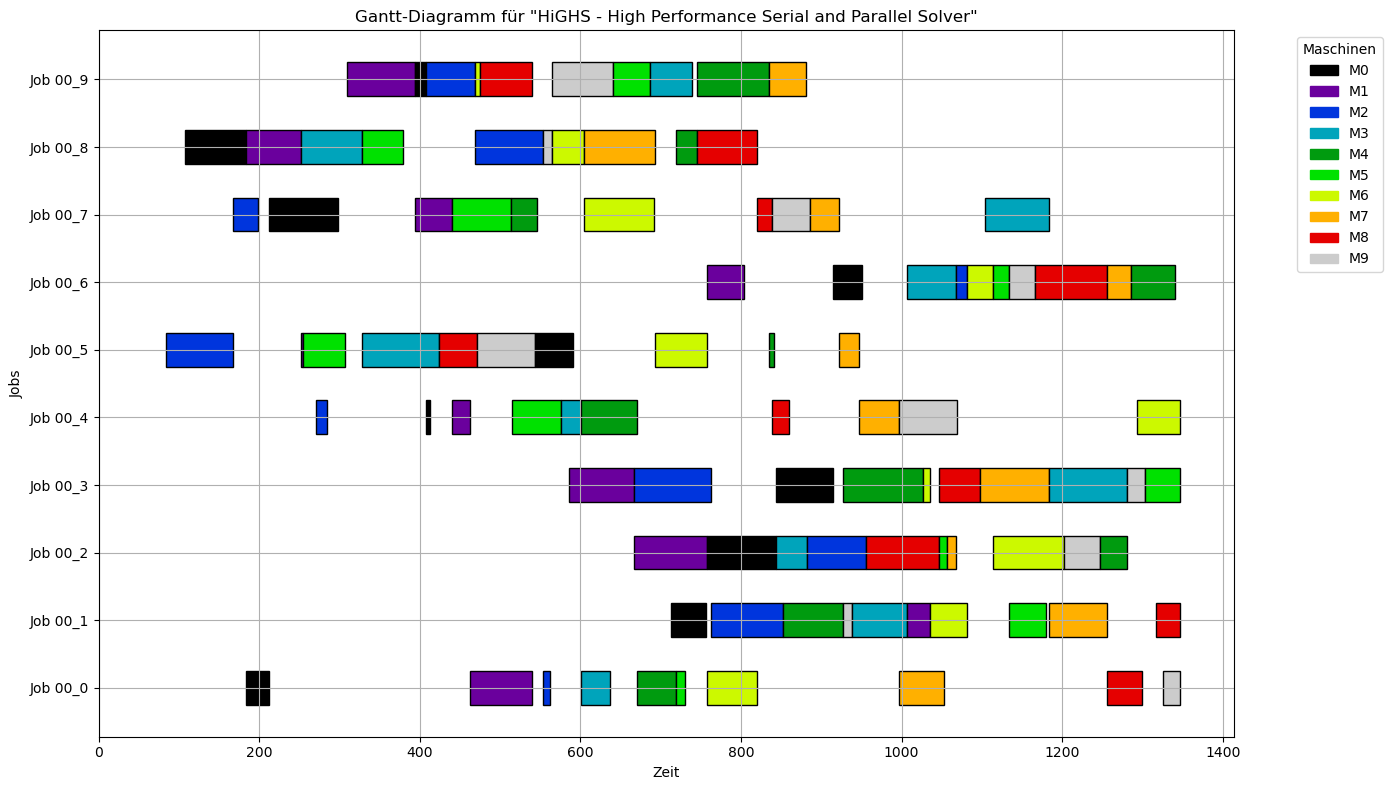

	✅ Alle Constraints wurden erfüllt.



True

In [9]:
# Schritt 2: Erster Jobshop-Solver (Stage 1)
df_schedule_highs, opt_makespan = solve_jobshop_optimal(this_day_jobs, df_arrivals, day_id=matrix_index, solver_time_limit=1000)
print(f"Stage 1 - Optimaler Makespan: {opt_makespan} Zeiteinheiten")

# Schritt 3: Zweiter Solver für frühe Starts (Stage 2)
df_schedule_early_starts, final_makespan = solve_stage2_early_starts(this_day_jobs, df_arrivals, opt_makespan, day_id=matrix_index)

category = "HiGHS - High Performance Serial and Parallel Solver"
plot_gantt_jobs(df_schedule_early_starts, 'Gantt-Diagramm für "{}"'.format(category))

# Überprüfen
check_all_constraints(df_schedule_early_starts, this_day_jobs, df_arrivals)

In [10]:
# Schritt 4: Zeitplan aufteilen
df_schedule_on_time, df_late = edit.separate_operation_by_day_limit(df_schedule_early_starts, day_limit_h=21)

# Schritt 5: Übrig gebliebene Jobs extrahieren oder None setzen
remaining_jobs = edit.get_jssp_from_schedule(df_late) if not df_late.empty else None
remaining_jobs

{'Job 00_0': [[8, 44], [9, 21]],
 'Job 00_1': [[8, 30]],
 'Job 00_2': [[4, 33]],
 'Job 00_3': [[3, 98], [9, 22], [5, 43]],
 'Job 00_4': [[6, 53]],
 'Job 00_6': [[7, 30], [4, 55]]}

## Days iterativ

In [12]:
def plan_day(matrix_index, this_day_jobs, remaining_jobs, solver_time_limit=300, working_day_hours=24):
    print(f"\n==== Tag {matrix_index} ====")

    # Schritt 1: neue Ankunftszeiten erzeugen
    df_arrivals = generate_job_arrivals(this_day_jobs, u_b_mmax=0.9, day_id=matrix_index)

    # Falls noch verbliebene Job-Operationen vom Vortag da sind, hinzufügen
    if remaining_jobs is not None:
        df_arrivals = edit.add_remaining_jobs_with_zero_arrival(df_arrivals, remaining_jobs, day_id=matrix_index)
        this_day_jobs = edit.merge_jssp_jobs(this_day_jobs, remaining_jobs)
        print(f"\tJobs vom Vortag werden berücksichtigt!")

    # Schritt 2: Erster Jobshop-Solver (Stage 1)
    df_schedule_highs, opt_makespan = solve_jobshop_optimal(
        this_day_jobs, df_arrivals, day_id=matrix_index, solver_time_limit=solver_time_limit
    )

    # Schritt 3: Zweiter Solver für frühe Starts (Stage 2)
    df_schedule_early_starts, final_makespan = solve_stage2_early_starts(
        this_day_jobs, df_arrivals, opt_makespan, day_id=matrix_index, solver_time_limit=solver_time_limit
    )
    print(f"\tFinaler Makespan: {final_makespan} Minuten")

    # Überprüfen
    check_all_constraints(df_schedule_early_starts, this_day_jobs, df_arrivals)

    # Schritt 4: Zeitplan aufteilen
    df_schedule_on_time, df_late = edit.separate_operation_by_day_limit(df_schedule_early_starts, day_limit_h=working_day_hours)

    # Schritt 5: Übrig gebliebene Jobs extrahieren
    remaining_jobs = edit.get_jssp_from_schedule(df_late) if not df_late.empty else None

    if remaining_jobs is not None:
        print(f"\tAnzahl verbliebener Operationen für nächsten Tag: {len(remaining_jobs)}")
    else:
        print(f"\tAlle Jobs abgeschlossen, keine Überträge auf den nächsten Tag.")

    # Nur zurückgeben, nicht zusammenbauen!
    return remaining_jobs, df_schedule_on_time



In [13]:
job_set_list = create_job_matrix_variants_list(instance, 2)

In [14]:
df_schedule_daily = pd.DataFrame()
remaining_jobs = None

for matrix_index, this_day_jobs in enumerate(job_set_list):
    remaining_jobs, df_schedule_on_time = plan_day(matrix_index, this_day_jobs, remaining_jobs, working_day_hours=21)
    df_schedule_daily = pd.concat([df_schedule_daily, df_schedule_on_time], ignore_index=True)

df_schedule_daily


==== Tag 0 ====
	Finaler Makespan: 1346.37 Minuten
	✅ Alle Constraints wurden erfüllt.

	Anzahl verbliebener Operationen für nächsten Tag: 6

==== Tag 1 ====
	Jobs vom Vortag werden berücksichtigt!
	Finaler Makespan: 1346.25 Minuten
	✅ Alle Constraints wurden erfüllt.

	Anzahl verbliebener Operationen für nächsten Tag: 8


,Job,Machine,Day-ID,Start,Duration,End
0,Job 00_0,M0,0,183.28,29,212.28
1,Job 00_0,M1,0,462.31,78,540.31
2,Job 00_0,M2,0,553.25,9,562.25
3,Job 00_0,M3,0,601.31,36,637.31
4,Job 00_0,M4,0,670.31,49,719.31
...,...,...,...,...,...,...
181,Job 01_9,M9,1,564.25,76,640.25
182,Job 01_9,M5,1,640.25,47,687.25
183,Job 01_9,M3,1,687.25,52,739.25
184,Job 01_9,M4,1,739.25,90,829.25


# Pseudo-Simulation (ohne Abweichungen)

In [16]:
def plan_days_in_horizon(current_day, planning_horizon, job_set_list, remaining_jobs, remaining_jobs_current_day, max_solver_time, working_day_hours=24):
    df_schedule_daily = pd.DataFrame()

    for day_id in range(current_day, current_day + planning_horizon):
        if day_id >= len(job_set_list):
            print(f" Tag {day_id} überschreitet die verfügbare Instanzliste. Abbruch.")
            break
        
        this_day_jobs = job_set_list[day_id]

        remaining_jobs, df_schedule_planned_on_time = plan_day(day_id, this_day_jobs, remaining_jobs, max_solver_time, working_day_hours)
        df_schedule_daily = pd.concat([df_schedule_daily, df_schedule_planned_on_time], ignore_index=True)

        # --- Platzhalter für Simulation von Ereignissen ---
        # Simulation (optional)
        # sim_execution, sim_remaining_jobs = simulate_events(df_schedule_planned_on_time)
        # remaining_jobs = merge_remaining_jobs(remaining_jobs, sim_remaining_jobs)
        
        if day_id == current_day:
            remaining_jobs_current_day = remaining_jobs

    return df_schedule_daily, remaining_jobs_current_day



def run_simulation(df_schedule_daily_list, job_set_list, current_day, remaining_jobs_current_day, total_simulation_days, max_planning_horizon, max_solver_time, working_day_hours=24):
    while current_day < total_simulation_days:
        remaining_jobs = remaining_jobs_current_day
        print(f"\n####### Planung ab Simulationstag {current_day} #######")

        planning_horizon = min(max_planning_horizon, total_simulation_days - current_day)
        print(f" Planungshorizont: {planning_horizon} Tage (von Tag {current_day} bis {current_day + planning_horizon - 1})")

        df_schedule_daily, remaining_jobs_current_day = plan_days_in_horizon(
            current_day, planning_horizon, job_set_list, remaining_jobs, 
            remaining_jobs_current_day, max_solver_time, working_day_hours
        )
        
        df_schedule_daily_list.append(df_schedule_daily)

        current_day += 1

    return df_schedule_daily_list


In [17]:
import pandas as pd

# --- Parameter setzen ---
total_simulation_days = 4
max_planning_horizon = 3
max_solver_time = 120  # Sekunden 
working_day_hours = 21

# --- Setup ---
df_schedule_daily_list = []
job_set_list = create_job_matrix_variants_list(instance, total_simulation_days)
current_day = 0
remaining_jobs_current_day = None

# --- Simulation starten ---
df_schedule_daily_list = run_simulation(
    df_schedule_daily_list,
    job_set_list,
    current_day,
    remaining_jobs_current_day,
    total_simulation_days,
    max_planning_horizon,
    max_solver_time,
    working_day_hours
)



####### Planung ab Simulationstag 0 #######
 Planungshorizont: 3 Tage (von Tag 0 bis 2)

==== Tag 0 ====
	Finaler Makespan: 1346.37 Minuten
	✅ Alle Constraints wurden erfüllt.

	Anzahl verbliebener Operationen für nächsten Tag: 6

==== Tag 1 ====
	Jobs vom Vortag werden berücksichtigt!
	Finaler Makespan: 1346.25 Minuten
	✅ Alle Constraints wurden erfüllt.

	Anzahl verbliebener Operationen für nächsten Tag: 8

==== Tag 2 ====
	Jobs vom Vortag werden berücksichtigt!
	Finaler Makespan: 1346.31 Minuten
	✅ Alle Constraints wurden erfüllt.

	Anzahl verbliebener Operationen für nächsten Tag: 7

####### Planung ab Simulationstag 1 #######
 Planungshorizont: 3 Tage (von Tag 1 bis 3)

==== Tag 1 ====
	Jobs vom Vortag werden berücksichtigt!
	Finaler Makespan: 1346.25 Minuten
	✅ Alle Constraints wurden erfüllt.

	Anzahl verbliebener Operationen für nächsten Tag: 8

==== Tag 2 ====
	Jobs vom Vortag werden berücksichtigt!
	Finaler Makespan: 1346.31 Minuten
	✅ Alle Constraints wurden erfüllt.

	Anza

### Export

In [19]:
df_schedules_output = pd.concat(
    [
        df.assign(Plan_ID=i)[['Plan_ID'] + df.columns.tolist()]
        for i, df in enumerate(df_schedule_daily_list)
    ],
    ignore_index=True
)
df_schedules_output 

,Plan_ID,Job,Machine,Day-ID,Start,Duration,End
0,0,Job 00_0,M0,0,183.28,29,212.28
1,0,Job 00_0,M1,0,462.31,78,540.31
2,0,Job 00_0,M2,0,553.25,9,562.25
3,0,Job 00_0,M3,0,601.31,36,637.31
4,0,Job 00_0,M4,0,670.31,49,719.31
...,...,...,...,...,...,...,...
880,3,Job 03_9,M8,3,475.13,64,539.13
881,3,Job 03_9,M9,3,564.25,76,640.25
882,3,Job 03_9,M5,3,640.25,47,687.25
883,3,Job 03_9,M3,3,774.37,52,826.37


In [20]:
df_schedules_output.to_csv("output/05_schedule_plans.csv", index=False)